# Clad Data--- predicting the characteristics of the clad

This Project show that the methods generate models that not only demonstrate good agreement with  data

The data is scraped from `http://senvol.com/`


http://senvol.com/5_material-results/?appSession=0LTD9N6NY50DFEC28SO9N86TP49WFI6R6GEO4242743X1UP61EW017ASO6LS75SQX9CX2NW0G6Z6G8S456523E2RT203784AYQ578JEI6N0Q1I1MF957ZES52XGY3K38&PageID=2&PrevPageID=&cpipage={page_num}&CPISortType=&CPIorderBy=&appSession=26D32R65NSJT4F758HXOR2LE407P1479FX808Z5288IX77J2J5XK0RJX1Q99KFV05V5FF5K5Z1PHFF754130M6P3SQZ7CU1KUE5J5O367I9OG0YOL8WD1HH6D2D3F802&PageID=2&PrevPageID=&cpipage=2&CPISortType=&CPIorderBy=


## About the features

1. **Author/Paper**: This refers to the author(s) of a research paper or the title of the paper itself. In the field of additive manufacturing, there is a significant amount of research published in academic journals and conference proceedings, and referencing the author or paper helps to identify the source of information.

2. **Powder Material**: Additive manufacturing processes such as powder bed fusion (e.g., selective laser melting, electron beam melting) use powdered materials as the feedstock. The "Powder Material" refers to the specific material used in the additive manufacturing process. This could include metals, polymers, ceramics, or composites, among others.

3. **Substrate Material**: In some additive manufacturing processes, especially those that involve layer-by-layer deposition, a substrate material may be used as a base or support structure for the fabrication of the desired object. The "Substrate Material" refers to the material of this base or support structure.

4. **Spot Size (mm)**: This refers to the diameter or dimensions of the focused energy spot used in processes like laser-based additive manufacturing. It indicates the size of the area where the energy is concentrated to melt or fuse the material.

5. **Power (W)**: This represents the power of the energy source used in the additive manufacturing process. For example, in laser-based processes, it could refer to the power of the laser source, which influences the rate of melting or sintering of the material.

6. **Mass Flowrate (g/min)**: Mass flow rate indicates the amount of material (in grams) delivered per unit of time (in minutes). In additive manufacturing, it typically refers to the rate at which powdered material or filament is fed into the system for deposition or melting.

7. **Travel Velocity (mm/min)**: This represents the speed at which the print head or deposition mechanism moves during the additive manufacturing process. It influences the build time, surface finish, and mechanical properties of the printed part.

8. **Height (mm)**: This refers to the height or thickness of the printed layers in the additive manufacturing process. It determines the resolution and layer thickness of the fabricated object.

9. **Width (mm)**: Width typically refers to the width of the printed traces or lines deposited by the printing nozzle or laser beam. It contributes to the overall dimensions and accuracy of the printed part.

10. **Contact Angle (deg)**: This could refer to the angle at which the printing nozzle or deposition mechanism contacts the build surface or substrate during the additive manufacturing process. It may influence adhesion and surface quality.

11. **Aspect Ratio (H/W)**: The aspect ratio is the ratio of the height (H) to the width (W) of an object or feature. In additive manufacturing, it refers to the ratio of the height of a printed object to its width, providing information about the geometry and shape of the fabricated part.


In [ ]:
!pip install --q bayesian-optimization

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.keras.backend.clear_session()
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import xgboost
import seaborn as sns
import matplotlib.font_manager

from sklearn.metrics import accuracy_score, r2_score, mean_squared_error,mean_absolute_error, explained_variance_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, IsolationForest
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn import svm

from bayes_opt import BayesianOptimization

In [ ]:
data = pd.read_csv('/content/AM_MasterData.csv', encoding='unicode_escape')
data

,Author/Paper,Powder Material,Substrate Material,Spot Size (mm),Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Width (mm),Contact Angle (deg),Aspect Ratio (H/W)
0,El Cheikh,316L,316L,0.53,180,1.5000,300.0,0.470,0.56,NaN,0.839
1,El Cheikh,316L,316L,0.53,180,1.5000,600.0,0.190,0.50,NaN,0.380
2,El Cheikh,316L,316L,0.53,180,1.5000,900.0,0.150,0.43,NaN,0.349
3,El Cheikh,316L,316L,0.53,180,3.0000,300.0,0.730,0.41,NaN,1.780
4,El Cheikh,316L,316L,0.53,180,3.0000,600.0,0.390,0.38,NaN,1.026
...,...,...,...,...,...,...,...,...,...,...,...
382,Nabhani,Ti-6Al-4V,Ti-6Al-4V,2.00,300,30.0000,240.0,NaN,1.69,129.98,NaN
383,Nabhani,Ti-6Al-4V,Ti-6Al-4V,2.00,300,36.0000,120.0,0.810,1.89,130.94,0.429
384,Nabhani,Ti-6Al-4V,Ti-6Al-4V,2.00,300,36.0000,180.0,0.520,1.89,129.03,0.275
385,Nabhani,Ti-6Al-4V,Ti-6Al-4V,2.00,300,36.0000,240.0,0.200,1.60,125.10,0.125


# Univariate

In [ ]:
import altair as alt
chart = alt.Chart(data).mark_point().encode(
    x='Height (mm)',
    y='Width (mm)',
    color='Aspect Ratio (H/W)'
).interactive()
chart

alt.Chart(...)

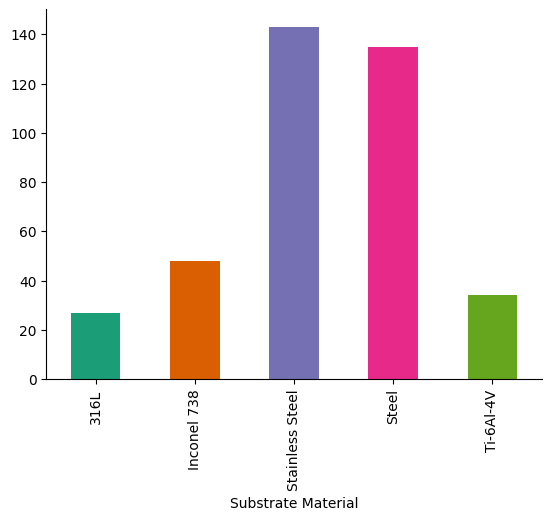

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Substrate Material').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

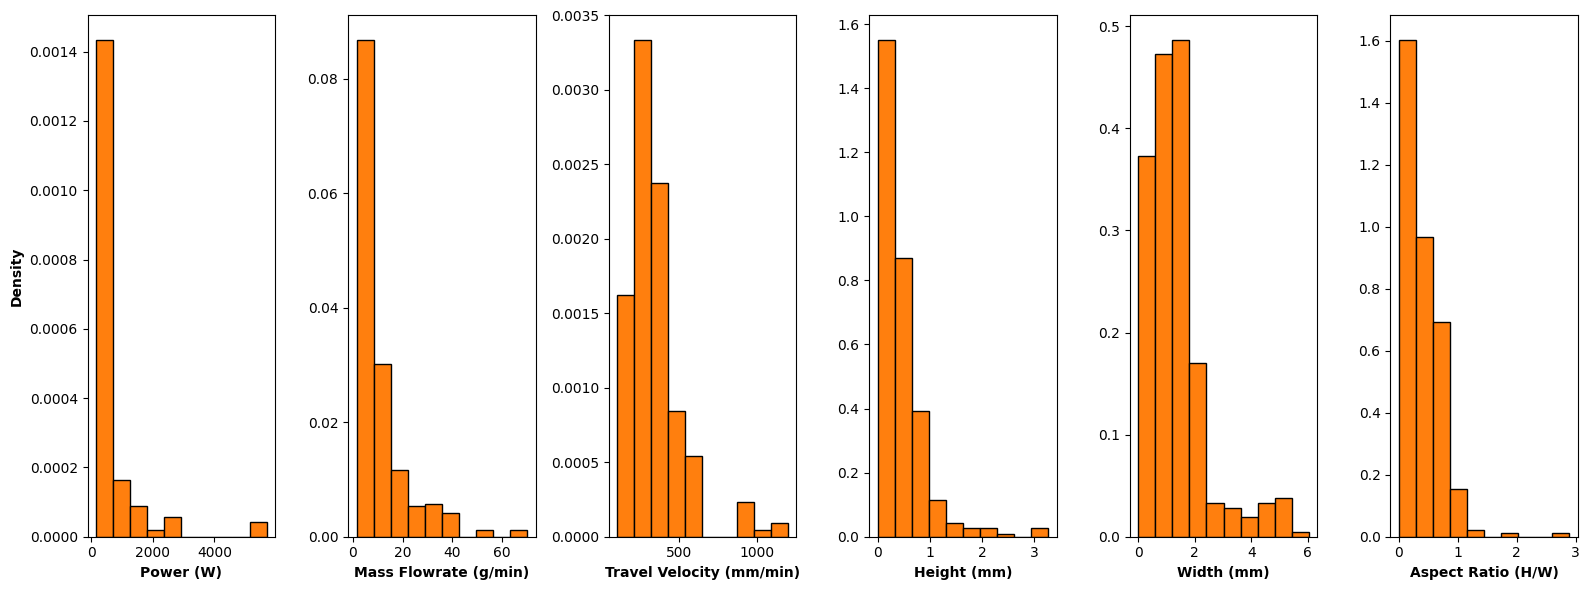

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(16, 6), tight_layout=True)
ax1.hist(data['Power (W)'], density=True, color='tab:orange', edgecolor='k')
#ax1.grid()
ax1.set_ylabel('Density', weight='bold')
ax1.set_xlabel('Power (W)', weight='bold' )
ax2.hist(data['Mass Flowrate (g/min)'], density=True, color='tab:orange', edgecolor='k')
#ax2.grid()
ax2.set_xlabel('Mass Flowrate (g/min)', weight='bold')
ax3.hist(data['Travel Velocity (mm/min)'], density=True, color='tab:orange', edgecolor='k')
#ax3.grid()
ax3.set_xlabel('Travel Velocity (mm/min)', weight='bold')
ax4.hist(data['Height (mm)'], density=True, color='tab:orange', edgecolor='k')
#ax4.grid()
ax4.set_xlabel('Height (mm)', weight='bold')
ax5.hist(data['Width (mm)'], density=True, color='tab:orange', edgecolor='k')
#ax5.grid()
ax5.set_xlabel('Width (mm)', weight='bold')
ax6.hist(data['Aspect Ratio (H/W)'], density=True, color='tab:orange', edgecolor='k')
#ax6.grid()
ax6.set_xlabel('Aspect Ratio (H/W)', weight='bold')
plt.savefig('Dataset.png', dpi=600)
plt.show()

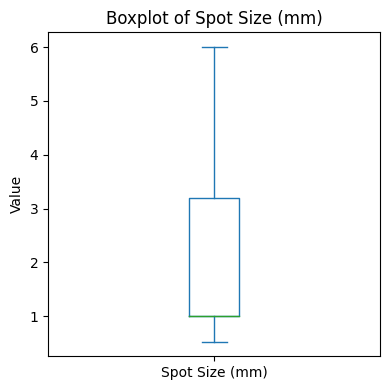

In [ ]:
data['Spot Size (mm)'].plot(kind='box', figsize=(4, 4))
plt.title('Boxplot of Spot Size (mm)')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

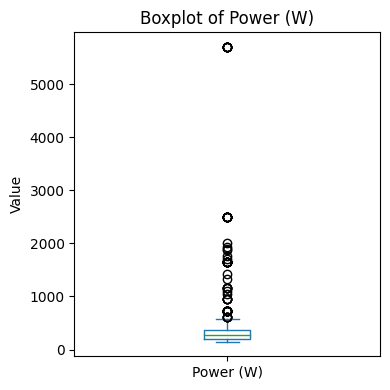

In [ ]:
data['Power (W)'].plot(kind='box', figsize=(4, 4))
plt.title('Boxplot of Power (W)')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

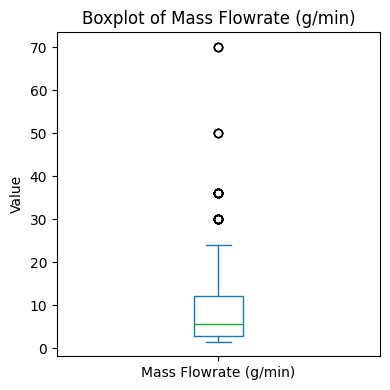

In [ ]:
data['Mass Flowrate (g/min)'].plot(kind='box', figsize=(4, 4
                                                        ))
plt.title('Boxplot of Mass Flowrate (g/min)')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

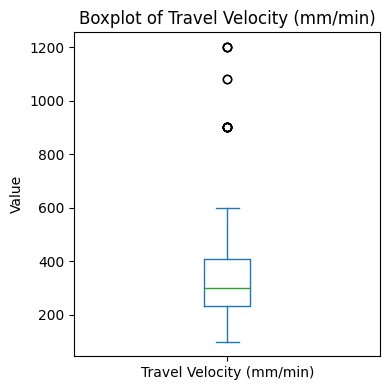

In [ ]:
data['Travel Velocity (mm/min)'].plot(kind='box', figsize=(4, 4))
plt.title('Boxplot of Travel Velocity (mm/min)')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

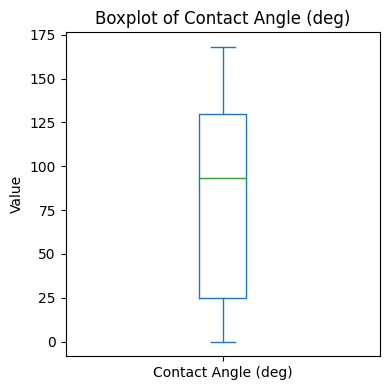

In [ ]:
data['Contact Angle (deg)'].plot(kind='box', figsize=(4, 4))
plt.title('Boxplot of Contact Angle (deg)')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

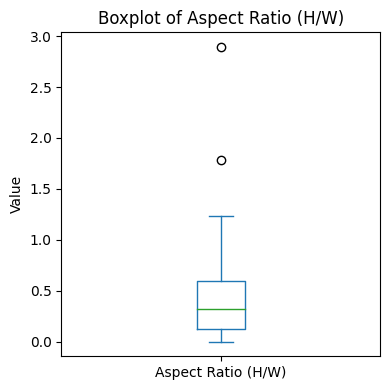

In [ ]:
data['Aspect Ratio (H/W)'].plot(kind='box', figsize=(4, 4))
plt.title('Boxplot of Aspect Ratio (H/W)')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

+ From the above box plots it is clear that we need to do box cox transformation

# Bivariate Analysis

<ipython-input-13-2a312666ca8d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Travel Velocity (mm/min)', y='Substrate Material', inner='stick', palette='Dark2')


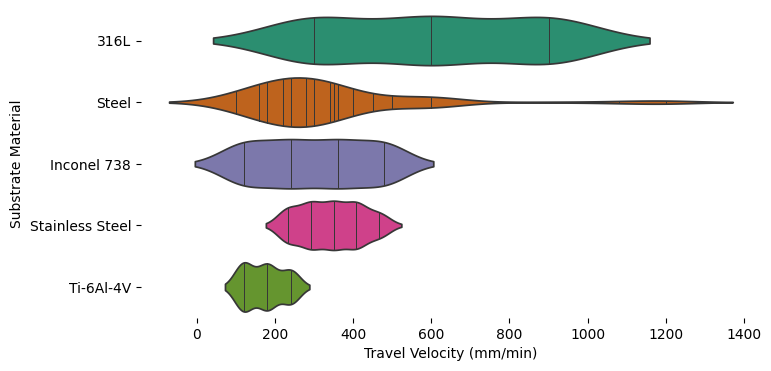

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (8, 4)
plt.figure(figsize=figsize)
sns.violinplot(data, x='Travel Velocity (mm/min)', y='Substrate Material', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-14-0e31b6c34d50>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Mass Flowrate (g/min)', y='Substrate Material', inner='stick', palette='Dark2')


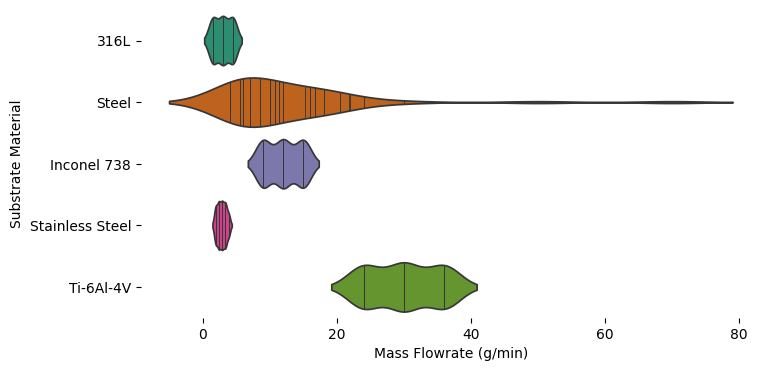

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (8, 4)
plt.figure(figsize=figsize)
sns.violinplot(data, x='Mass Flowrate (g/min)', y='Substrate Material', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-15-20d27162dc48>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Power (W)', y='Substrate Material', inner='stick', palette='Dark2')


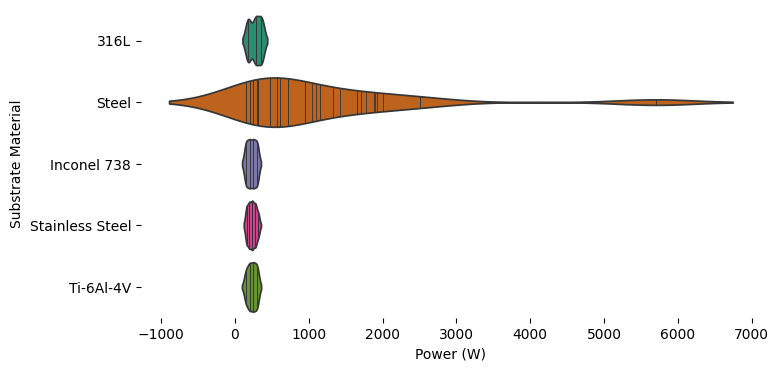

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (8, 4)
plt.figure(figsize=figsize)
sns.violinplot(data, x='Power (W)', y='Substrate Material', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-16-79afe7a1ece9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Spot Size (mm)', y='Substrate Material', inner='stick', palette='Dark2')


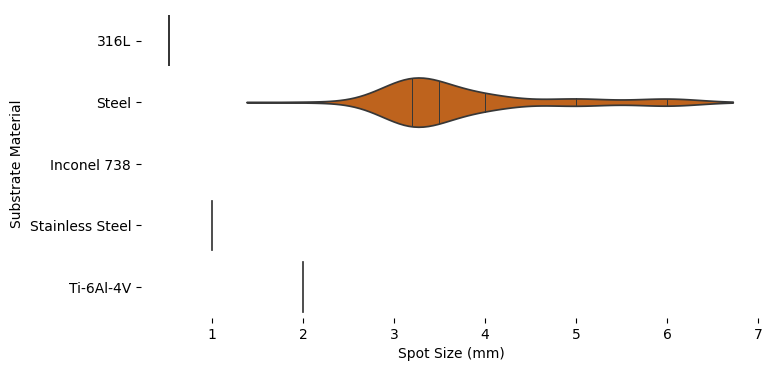

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (8, 4)
plt.figure(figsize=figsize)
sns.violinplot(data, x='Spot Size (mm)', y='Substrate Material', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.show()

In [ ]:
data.columns

Index(['Author/Paper', 'Powder Material', 'Substrate Material',
       'Spot Size (mm)', 'Power (W)', 'Mass Flowrate (g/min)',
       'Travel Velocity (mm/min)', 'Height (mm)', 'Width (mm)',
       'Contact Angle (deg)', 'Aspect Ratio (H/W)'],
      dtype='object')

In [ ]:
# Feature Engineering
Linear_Heat = 60 * (data['Power (W)']/data['Travel Velocity (mm/min)'])
LHI = pd.Series(Linear_Heat, name='Linear Heat Input (J/mm)')
data1 = data.join(LHI)

In [ ]:
# Drop The columns
data2 = data1.drop(columns=['Author/Paper', 'Height (mm)', 'Width (mm)', 'Contact Angle (deg)'])
data2.dropna(subset=['Aspect Ratio (H/W)'], inplace=True)

In [ ]:
FullDSPF = data1.drop(columns=['Author/Paper', 'Powder Material', 'Substrate Material', 'Spot Size (mm)', 'Contact Angle (deg)'])
PT = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
P = PT.fit_transform(FullDSPF)
PFDF = pd.DataFrame(P, columns=['Power (W)', 'Mass Flowrate (g/min)', 'Travel Velocity (mm/min)', 'Height (mm)', 'Width (mm)', 'Aspect Ratio (H/W)', 'Linear Heat Input (J/mm)'])

Box-Cox Equation

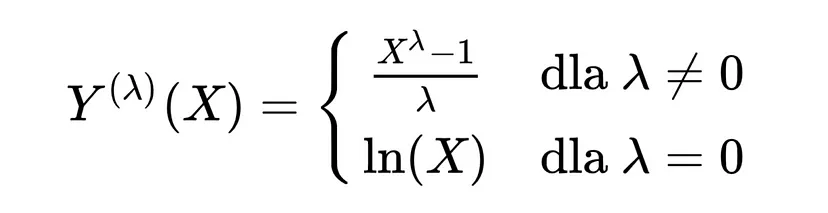

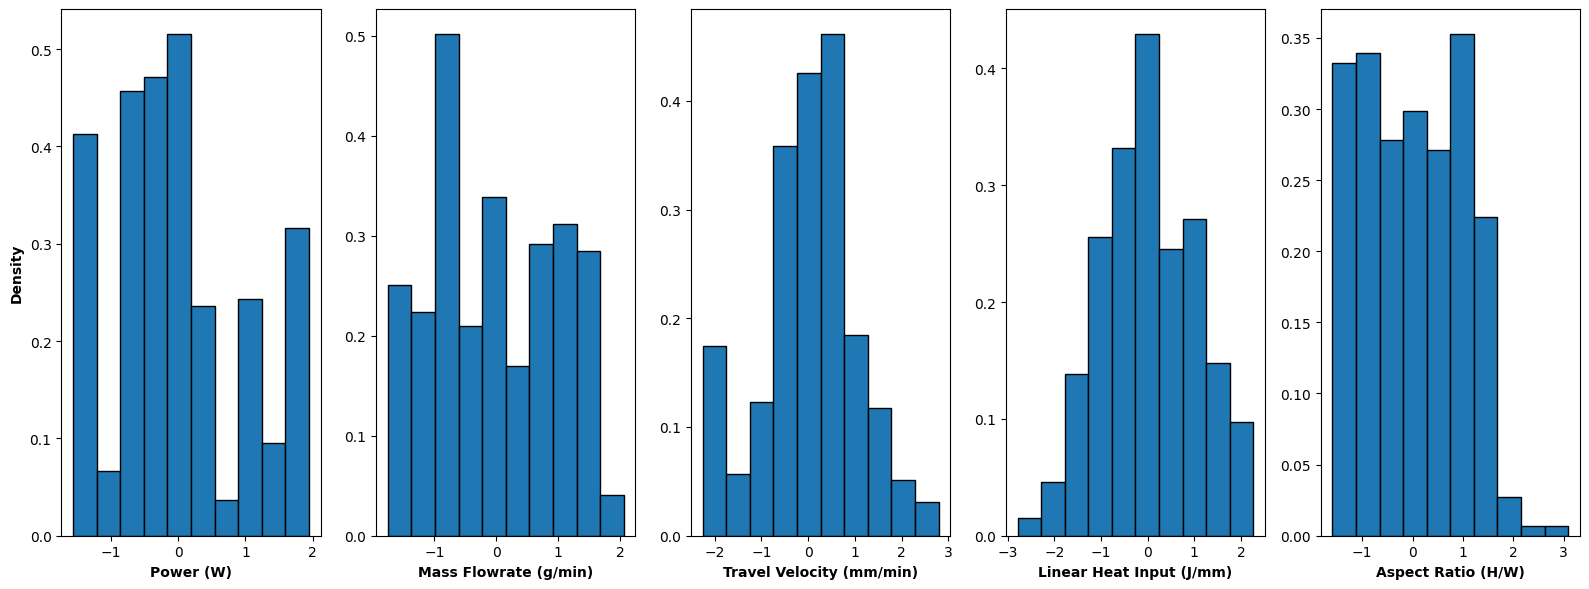

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 6), tight_layout=True)
ax1.hist(PFDF['Power (W)'], density=True, color='tab:blue', edgecolor='k')
ax1.set_ylabel('Density', weight='bold')
ax1.set_xlabel('Power (W)', weight='bold' )

ax2.hist(PFDF['Mass Flowrate (g/min)'], density=True, color='tab:blue', edgecolor='k')
ax2.set_xlabel('Mass Flowrate (g/min)', weight='bold')

ax3.hist(PFDF['Travel Velocity (mm/min)'], density=True, color='tab:blue', edgecolor='k')
ax3.set_xlabel('Travel Velocity (mm/min)', weight='bold')

ax5.hist(PFDF['Aspect Ratio (H/W)'], density=True, color='tab:blue', edgecolor='k')
ax5.set_xlabel('Aspect Ratio (H/W)', weight='bold')

ax4.hist(PFDF['Linear Heat Input (J/mm)'], density=True, color='tab:blue', edgecolor='k')
ax4.set_xlabel('Linear Heat Input (J/mm)', weight='bold')

plt.savefig('PTDataset.png', dpi=600)
plt.show()

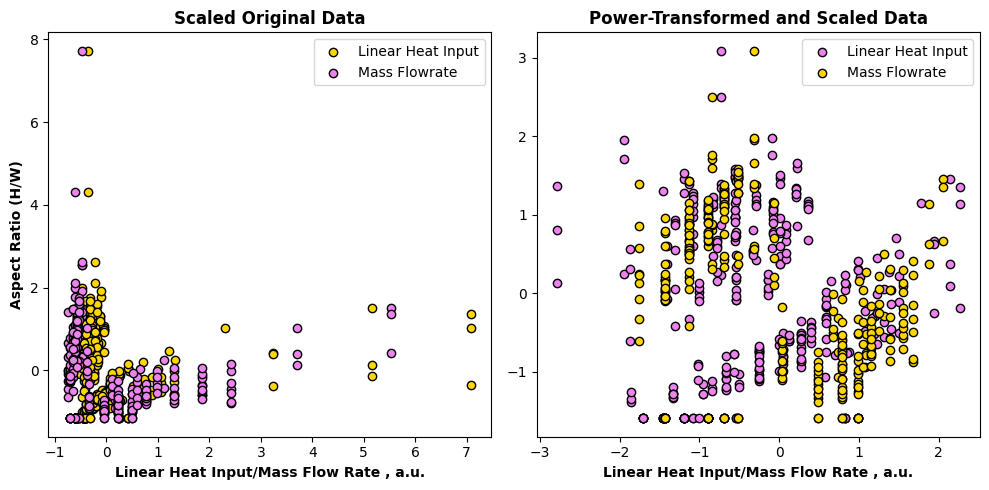

In [ ]:
sod = StandardScaler()
PlotDat = sod.fit_transform(data2[['Linear Heat Input (J/mm)','Mass Flowrate (g/min)','Aspect Ratio (H/W)']])
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
ax1.set_title("Scaled Original Data", weight='bold')
ax1.scatter(PlotDat[:,0],PlotDat[:,2], color='gold', edgecolors='k')
ax1.scatter(PlotDat[:,1],PlotDat[:,2], color='violet', edgecolors='k')
ax1.set_ylabel("Aspect Ratio (H/W)", weight='bold')
ax1.set_xlabel("Linear Heat Input/Mass Flow Rate , a.u.", weight='bold')
ax1.legend(("Linear Heat Input","Mass Flowrate"))
ax2.set_title("Power-Transformed and Scaled Data", weight='bold')
ax2.scatter(PFDF['Linear Heat Input (J/mm)'],PFDF['Aspect Ratio (H/W)'], color='violet', edgecolors='k')
ax2.scatter(PFDF['Mass Flowrate (g/min)'],PFDF['Aspect Ratio (H/W)'], color='gold', edgecolors='k')
ax2.set_xlabel("Linear Heat Input/Mass Flow Rate , a.u.", weight='bold')
ax2.legend(('Linear Heat Input','Mass Flowrate'))
plt.savefig('OrgtoPTDataset.png', dpi=600)
plt.show()

# Why prediction of aspect ratio

1. **Quality Control**: Aspect ratio can be an indicator of the quality of the printed parts. Deviations from the desired aspect ratio may signal issues such as poor dimensional accuracy, layer misalignment, or insufficient material deposition.

2. **Process Optimization**: Understanding how various process parameters affect the aspect ratio can help optimize the additive manufacturing process. By predicting the aspect ratio, researchers and engineers can identify optimal settings for parameters such as layer height, print speed, and material flow rate to achieve the desired aspect ratio.

3. **Design Considerations**: The aspect ratio of a printed part may be a critical design parameter in some applications. For example, in structures like columns or beams, the aspect ratio can affect mechanical properties such as stiffness, strength, and load-bearing capacity. Predicting the aspect ratio allows designers to tailor their designs to meet specific performance requirements.

4. **Quality Assurance**: Predicting the aspect ratio can serve as a quality assurance metric in additive manufacturing processes. By comparing predicted aspect ratios with target values, manufacturers can ensure that printed parts meet dimensional specifications and quality standards.

+ Overall, predicting the aspect ratio in additive manufacturing contributes to process understanding, quality control, and the optimization of printed parts for specific applications. It enables researchers and engineers to achieve better control over the manufacturing process and produce parts with desired geometrical and mechanical properties.

In [ ]:
# data Split
# Shuffle and Split Data
data2 = shuffle(data2, random_state=7)
X = data2.drop(columns='Aspect Ratio (H/W)')
y = data2['Aspect Ratio (H/W)']

In [ ]:
data2['Substrate Material'].value_counts()

Substrate Material
Stainless Steel    143
Steel               75
Inconel 738         48
316L                27
Ti-6Al-4V           22
Name: count, dtype: int64

In [ ]:
Impute_Features = ['Spot Size (mm)']
Numeric_Features = ['Mass Flowrate (g/min)', 'Linear Heat Input (J/mm)']
Categorical_Features = ['Powder Material', 'Substrate Material']

In [ ]:
colu = Impute_Features + Numeric_Features + Categorical_Features
colu

['Spot Size (mm)',
 'Mass Flowrate (g/min)',
 'Linear Heat Input (J/mm)',
 'Powder Material',
 'Substrate Material']

In [ ]:
power_transformer = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

impute_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

input_trans=[('impute', impute_transformer , Impute_Features),
      ('num', power_transformer, Numeric_Features),
      ('cat', OrdinalEncoder(), Categorical_Features)]

test_trans=[('impute', impute_transformer , Impute_Features),
      ('num', 'passthrough', Numeric_Features),
      ('cat', OrdinalEncoder(), Categorical_Features)]

In [ ]:
Input_preprocessor = ColumnTransformer(transformers=input_trans)
Output_preprocessor = power_transformer
Test_preprocessor = ColumnTransformer(transformers=test_trans)

In [ ]:
Xrc = Input_preprocessor.fit_transform(X)
yr = Output_preprocessor.fit_transform(y.values.reshape(-1,1))
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xrc, yr, test_size=.2, random_state=69)

In [ ]:
col_dataframe=pd.DataFrame(Xrc, columns=colu)
col_dataframe

,Spot Size (mm),Mass Flowrate (g/min),Linear Heat Input (J/mm),Powder Material,Substrate Material
0,2.983757e-01,1.401560,1.303850,8.0,4.0
1,-1.830886e-16,0.860548,0.022114,9.0,3.0
2,3.596607e+00,1.138324,1.164054,1.0,3.0
3,-1.830886e-16,0.587557,-0.443646,6.0,1.0
4,-5.261822e-01,-1.321818,-1.052627,7.0,2.0
...,...,...,...,...,...
310,-5.261822e-01,-1.321818,0.136167,7.0,2.0
311,-1.830886e-16,1.052194,-0.265586,6.0,1.0
312,-9.137244e-01,-0.189091,-0.986182,0.0,0.0
313,-5.261822e-01,-1.010148,-1.191484,7.0,2.0


In [ ]:
bins = pd.IntervalIndex.from_tuples([(-.01, .375), (.375, .425), (.425, .475), (.475,.525), (.525,.575), (.575,.625), (.625,2.9)])
AR = pd.cut(y, bins=bins)
AR1 = AR.to_numpy()


LE = preprocessing.LabelEncoder()
OHE = preprocessing.OneHotEncoder()

yc = LE.fit_transform(AR)
ycn = OHE.fit_transform(AR1.reshape(-1,1))


Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xrc, yc, test_size=.2)
Xcn_train, Xcn_test, ycn_train, ycn_test = train_test_split(Xrc, ycn, test_size=.2)

In [ ]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
ones = np.ones((xx.ravel().shape[0],1))
PM = np.array(['PH13-8']*xx.ravel().shape[0], dtype=object).reshape(-1,1)
SM = np.array(['Stainless Steel']*xx.ravel().shape[0], dtype=object).reshape(-1,1)
Spot_Size = .75
TestDF = pd.DataFrame(np.column_stack(tup=[PM, SM, Spot_Size*ones, ones, yy.ravel(), ones, xx.ravel()]),
        columns=['Powder Material', 'Substrate Material','Spot Size (mm)','Power (W)', 'Mass Flowrate (g/min)',
                 'Traverse Velocity (mm/min)', 'Linear Heat Input (J/mm)'])
Test_preprocessor.fit(X)
rcTest = Test_preprocessor.transform(TestDF)

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
# Create an instance of the XGBRegressor
lr_model_reg = LinearRegression()
lr_model_reg.fit(Xr_train, yr_train)
# Make predictions on the test set
y_pred_reg = lr_model_reg.predict(Xr_test)

# Regression Metrics
mse = mean_squared_error(yr_test, y_pred_reg)#y test and y pred
mae = mean_absolute_error(yr_test, y_pred_reg)
r2 = r2_score(yr_test, y_pred_reg)
explained_var = explained_variance_score(yr_test, y_pred_reg)

# Display the regression metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Explained Variance Score:", explained_var)

Mean Squared Error (MSE): 0.6859727703440082
Mean Absolute Error (MAE): 0.6052346229820094
R-squared (R2): 0.31871703752629543
Explained Variance Score: 0.3202491082957074


# SVM

In [ ]:
from sklearn import svm
SVR = svm.SVR(kernel='rbf',gamma='scale',C=5)
SVR.fit(Xr_train,yr_train)
y_pred_reg = SVR.predict(Xr_test)
r2SVR = r2_score(yr_test,y_pred_reg)
r2SVR

# Regression Metrics
mse = mean_squared_error(yr_test, y_pred_reg)#y test and y pred
mae = mean_absolute_error(yr_test, y_pred_reg)
r2 = r2_score(yr_test, y_pred_reg)
explained_var = explained_variance_score(yr_test, y_pred_reg)

# Display the regression metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Explained Variance Score:", explained_var)

Mean Squared Error (MSE): 0.47205235829885744
Mean Absolute Error (MAE): 0.48267214900878225
R-squared (R2): 0.5311749343297335
Explained Variance Score: 0.5347749450813392


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Gausssian Process

In [ ]:
kernel = (ConstantKernel() * RBF() + WhiteKernel()) + (ConstantKernel() * RBF() + WhiteKernel())
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, random_state=21)
gpr.fit(Xr_train, yr_train)
y_pred_reg = gpr.predict(Xr_test)
# Regression Metrics
mse = mean_squared_error(yr_test, y_pred_reg)#y test and y pred
mae = mean_absolute_error(yr_test, y_pred_reg)
r2 = r2_score(yr_test, y_pred_reg)
explained_var = explained_variance_score(yr_test, y_pred_reg)

# Display the regression metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Explained Variance Score:", explained_var)

Mean Squared Error (MSE): 0.296476843192776
Mean Absolute Error (MAE): 0.34454038354692806
R-squared (R2): 0.7055500877477494
Explained Variance Score: 0.7111161466708014


# Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
# Use Random Forest with class weights
rfr_model = RandomForestRegressor(random_state=42)
rfr_model.fit(Xr_train, yr_train)# x train and y train

# Make predictions on the test set
y_pred_reg = rfr_model.predict(Xr_test)#x test

# Regression Metrics
mse = mean_squared_error(yr_test, y_pred_reg)#y test and y pred
mae = mean_absolute_error(yr_test, y_pred_reg)
r2 = r2_score(yr_test, y_pred_reg)
explained_var = explained_variance_score(yr_test, y_pred_reg)

# Display the regression metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Explained Variance Score:", explained_var)

Mean Squared Error (MSE): 0.23376361979892366
Mean Absolute Error (MAE): 0.2756712894295708
R-squared (R2): 0.7678345580170469
Explained Variance Score: 0.7776027386699148


<ipython-input-37-18201244f8a5>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr_model.fit(Xr_train, yr_train)# x train and y train


In [ ]:
# Define the hyperparameters to tune
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num = 10)]
max_depth.append(None)
min_samples_split = [5, 10]
min_samples_leaf = [4, 6, 8]
ccp_alpha= [0.001,0.005,0.010,0.015,0.020]
random_grid_rfr = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion':["absolute_error"],
               'ccp_alpha' : ccp_alpha
               }
# Use RandomizedSearchCV to find the best hyperparameters
grid_search = RandomizedSearchCV(rfr_model, random_grid_rfr, cv=5, n_iter = 50, scoring='r2', n_jobs=-1)
grid_search.fit(Xr_train, yr_train)

# Get the best hyperparameters
rfr_best_params = grid_search.best_params_
print("Best Hyperparameters:", rfr_best_params)

# Evaluate the model with the best hyperparameters on the test set
rfr_best_model = grid_search.best_estimator_
y_pred_reg = rfr_best_model.predict(Xr_test)

# Regression Metrics
mse = mean_squared_error(yr_test, y_pred_reg)#y test and y pred
mae = mean_absolute_error(yr_test, y_pred_reg)
r2 = r2_score(yr_test, y_pred_reg)
explained_var = explained_variance_score(yr_test, y_pred_reg)

# Display the regression metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Explained Variance Score:", explained_var)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Hyperparameters: {'n_estimators': 559, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 45, 'criterion': 'absolute_error', 'ccp_alpha': 0.001}
Mean Squared Error (MSE): 0.373670570299794
Mean Absolute Error (MAE): 0.39160719953022094
R-squared (R2): 0.6288841130014309
Explained Variance Score: 0.6355794844656943


# XGBoost

In [ ]:
import xgboost
from xgboost import XGBRegressor
# Create an instance of the XGBRegressor
xg_model_reg = XGBRegressor(objective='reg:squarederror', max_depth=3, learning_rate=0.1, n_estimators=100)
xg_model_reg.fit(Xr_train, yr_train)
# Make predictions on the test set
y_pred_reg = xg_model_reg.predict(Xr_test)

# Regression Metrics
mse = mean_squared_error(yr_test, y_pred_reg)#y test and y pred
mae = mean_absolute_error(yr_test, y_pred_reg)
r2 = r2_score(yr_test, y_pred_reg)
explained_var = explained_variance_score(yr_test, y_pred_reg)

# Display the regression metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Explained Variance Score:", explained_var)

Mean Squared Error (MSE): 0.2303843081694857
Mean Absolute Error (MAE): 0.29691112072061376
R-squared (R2): 0.7711907662188254
Explained Variance Score: 0.7780812563013908


In [ ]:
# Define the hyperparameter grid for tuning
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150]
}

# Create GridSearchCV object
grid_search = RandomizedSearchCV(estimator=xg_model_reg, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=20)

# Perform Grid Search Cross Validation
grid_search.fit(Xr_train, yr_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred_reg = best_model.predict(Xr_test)

# Regression Metrics
mse = mean_squared_error(yr_test, y_pred_reg)#y test and y pred
mae = mean_absolute_error(yr_test, y_pred_reg)
r2 = r2_score(yr_test, y_pred_reg)
explained_var = explained_variance_score(yr_test, y_pred_reg)

# Display the regression metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Explained Variance Score:", explained_var)

Best Hyperparameters: {'objective': 'reg:squarederror', 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
Mean Squared Error (MSE): 0.2303843081694857
Mean Absolute Error (MAE): 0.29691112072061376
R-squared (R2): 0.7711907662188254
Explained Variance Score: 0.7780812563013908


In [ ]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: xlabel='importance', ylabel='feature'>

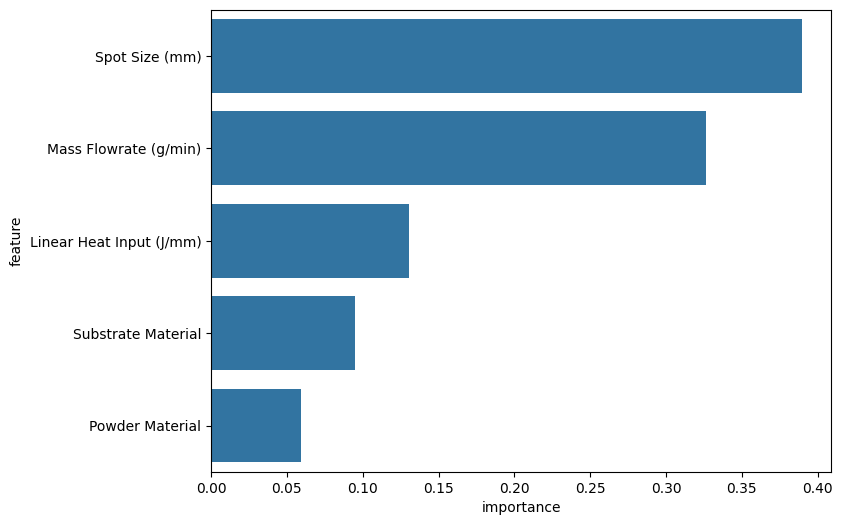

In [ ]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = col_dataframe.columns
feature_importance_df["importance"] = best_model.feature_importances_

feature_importance_df  = feature_importance_df.sort_values('importance', ascending=False).reset_index()
plt.figure(figsize = (8, 6))
sns.barplot(x ='importance', y ='feature', data= feature_importance_df[:20])

In [ ]:
!pip install --q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 9.8 MB/s eta 0:00:00


In [ ]:
import shap
shap.initjs()

In [ ]:
feature_names = colu
explainer = shap.Explainer(best_model)
shap_values = explainer(Xrc)

In [ ]:
colu

['Spot Size (mm)',
 'Mass Flowrate (g/min)',
 'Linear Heat Input (J/mm)',
 'Powder Material',
 'Substrate Material']

Global bar plot

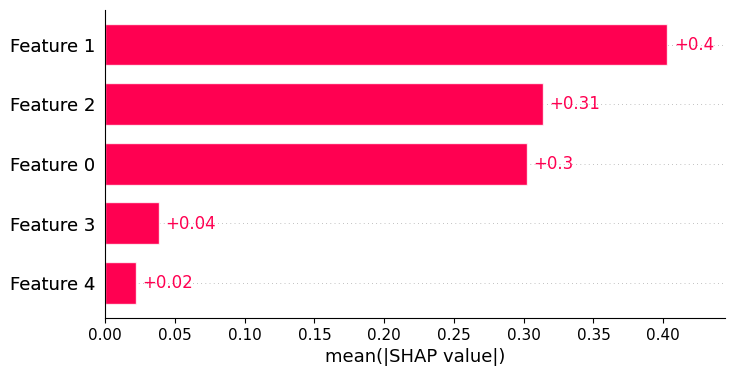

In [ ]:
shap.plots.bar(shap_values)

Local bar plot

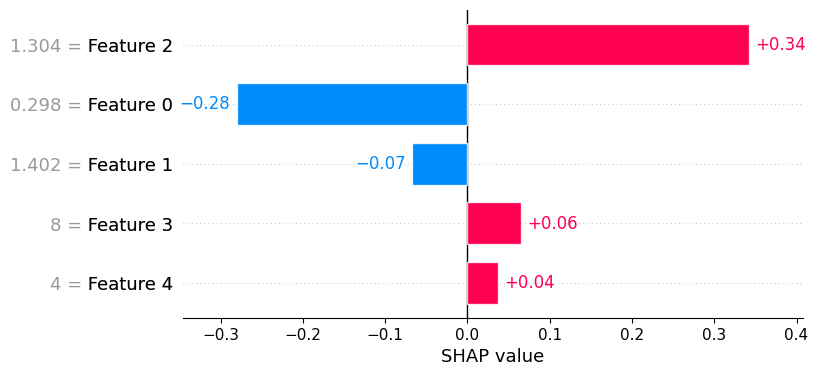

In [ ]:
shap.plots.bar(shap_values[0])

violin summary plot

+ violin summary plot offers a compact representation of the distribution and variability of SHAP values for each feature. Individual violin plots are stacked by importance of the particular feature on model output (sum of the absolute values of the SHAP values per feature).

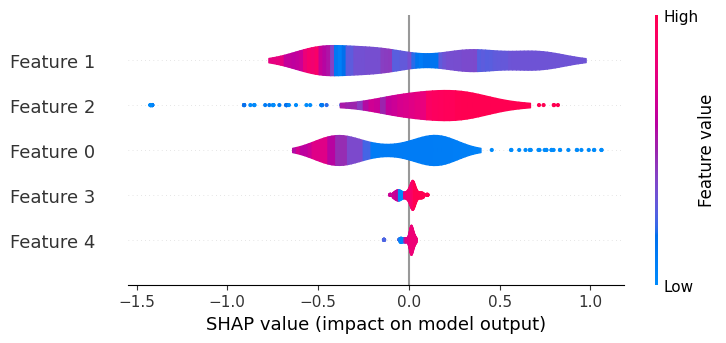

In [ ]:
shap.plots.violin(shap_values)

Waterfall plots
+ Waterfall plots are designed to display explanations for individual predictions, so they expect a single row of an Explanation object as input. The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

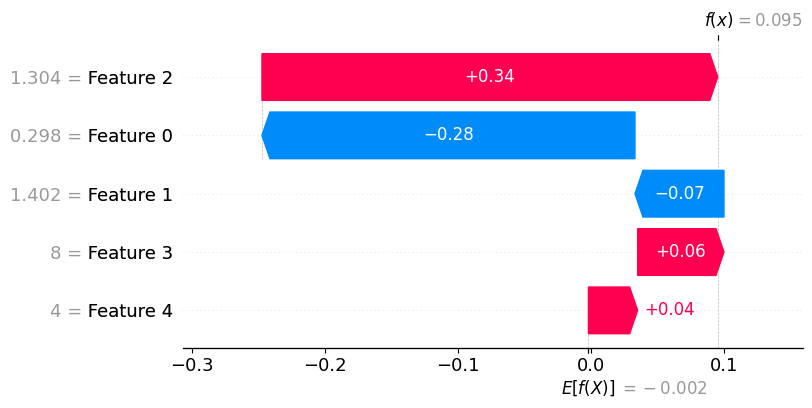

In [ ]:
shap.plots.waterfall(shap_values[0])

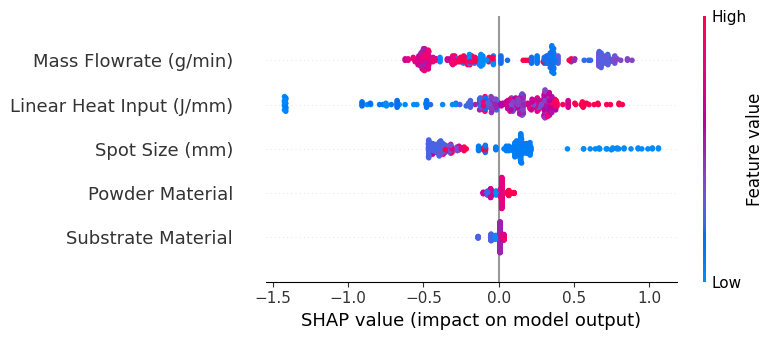

In [ ]:
shap.summary_plot(shap_values, pd.DataFrame(Xrc, columns=colu), feature_names = col_dataframe.columns)

Explainer Dashboard

In [ ]:
!pip install --q explainerdashboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.8/287.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.7 MB/s eta 0:00:00


In [ ]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard
explainer = RegressionExplainer(best_model, pd.DataFrame(Xr_test, columns=colu), pd.DataFrame(yr_test, columns=['Aspect Ratio']))
ExplainerDashboard(explainer).run()

Changing class type to XGBRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...


/usr/local/lib/python3.10/dist-packages/dash/dash.py:550: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Generating xgboost model dump...
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)


<IPython.core.display.Javascript object>

Dash app running on:


<IPython.core.display.Javascript object>